In [1]:
import random
                       
import pandas as pd                       
import matplotlib.pyplot as plt                       
import numpy as np

In [2]:
data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = data.values
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [3]:
from sklearn.model_selection import train_test_split
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [6]:
# normal_show = normal_train_data.loc[0:0, :]
# normal_show = np.array(normal_show).ravel()

# abnormal_show = anomalous_train_data.loc[0:0, :]
# abnormal_show = np.array(abnormal_show).ravel()

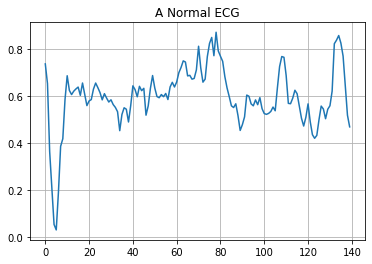

In [7]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

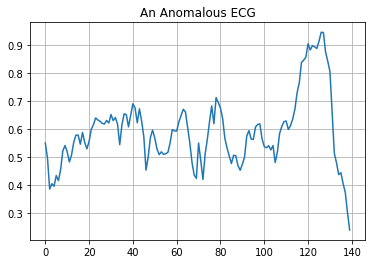

In [8]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [9]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(140, 70),
            nn.ReLU(),
            nn.Linear(70, 35),
            nn.ReLU()

        )
        self.dec = nn.Sequential(
            nn.Linear(35, 70),
            nn.ReLU(),
            nn.Linear(70, 140),
            nn.Sigmoid()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [10]:
import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [11]:
batch_size = 128
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 500

In [12]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset[idx]
        # row = row.drop(labels={'140'})
        data = torch.from_numpy(row).float()
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = normal_train_data

In [13]:
train_set = Train_Loader()
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=20,
            pin_memory=True,
            drop_last=True
        )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.L1Loss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [15]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-----------------------------------------------
[EPOCH] 1/500
[LOSS] 0.0010066860216863583
Epoch Complete in 0:00:00.973073
-----------------------------------------------
[EPOCH] 2/500
[LOSS] 0.0010058214953512698
Epoch Complete in 0:00:00.786693
-----------------------------------------------
[EPOCH] 3/500
[LOSS] 0.0010051340458503261
Epoch Complete in 0:00:00.775876
-----------------------------------------------
[EPOCH] 4/500
[LOSS] 0.0010044982924507855
Epoch Complete in 0:00:00.801216
-----------------------------------------------
[EPOCH] 5/500
[LOSS] 0.0010032030789717723
Epoch Complete in 0:00:00.792934
-----------------------------------------------
[EPOCH] 6/500
[LOSS] 0.0010025103802699161
Epoch Complete in 0:00:00.805944
-----------------------------------------------
[EPOCH] 7/500
[LOSS] 0.0010018266007879013
Epoch Complete in 0:00:00.825044
-----------------------------------------------
[EPOCH] 8/500
[LOSS] 0.001000742069135636
Epoch Complete in 0:00:00.767367
---------

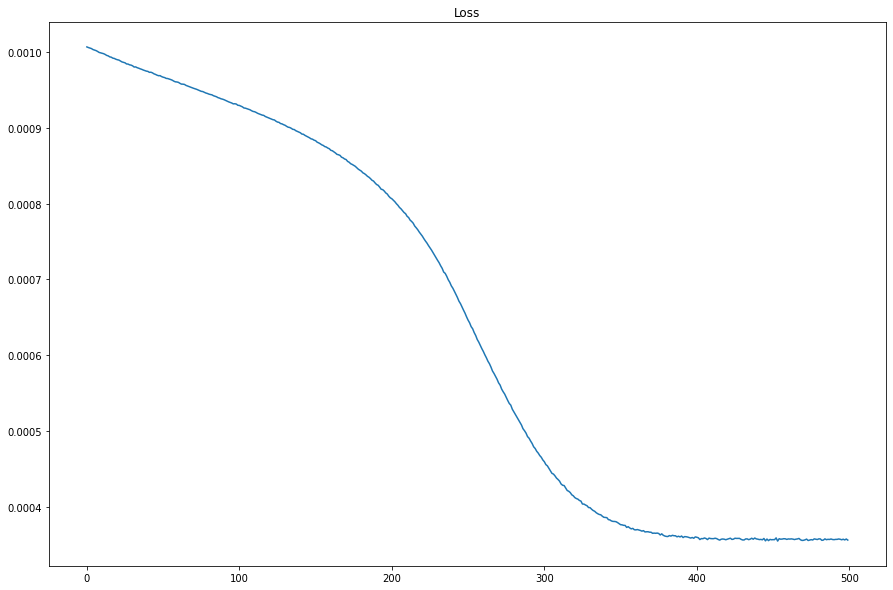

In [16]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [52]:
data = torch.from_numpy(np.array(normal_test_data)).float()
decoded_imgs = model(data.to(device))

if torch.cuda.is_available():
  decoded_imgs = decoded_imgs.to(torch.device("cpu"))
decoded_imgs = decoded_imgs.detach().numpy()
decoded_imgs


array([[0.54163504, 0.39569205, 0.2047899 , ..., 0.68237984, 0.63798183,
        0.41059482],
       [0.5409908 , 0.39694607, 0.20781271, ..., 0.6805253 , 0.63691974,
        0.41148424],
       [0.54123217, 0.39757353, 0.20608759, ..., 0.6809306 , 0.6385833 ,
        0.41065365],
       ...,
       [0.54081297, 0.39577186, 0.20549865, ..., 0.6818379 , 0.6376095 ,
        0.4098625 ],
       [0.5408552 , 0.39597604, 0.20861621, ..., 0.68023825, 0.6359115 ,
        0.4115986 ],
       [0.5413724 , 0.39653483, 0.20725836, ..., 0.6809636 , 0.6370802 ,
        0.4115801 ]], dtype=float32)

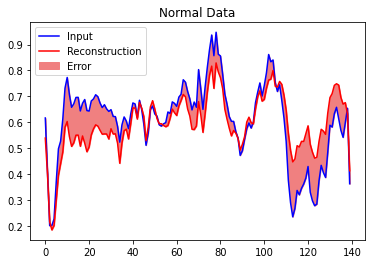

In [62]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('Normal Data')
plt.show()

In [54]:
data = torch.from_numpy(np.array(anomalous_test_data)).float()
decoded_imgs = model(data.to(device))

if torch.cuda.is_available():
  decoded_imgs = decoded_imgs.to(torch.device("cpu"))
decoded_imgs = decoded_imgs.detach().numpy()
decoded_imgs

array([[0.5389084 , 0.39906976, 0.2156973 , ..., 0.67593354, 0.63256764,
        0.41282377],
       [0.5398878 , 0.3970589 , 0.21107814, ..., 0.67867285, 0.6343179 ,
        0.4119151 ],
       [0.5406366 , 0.3965564 , 0.20974113, ..., 0.67954457, 0.63480896,
        0.41113275],
       ...,
       [0.5400778 , 0.39608935, 0.21037832, ..., 0.6794973 , 0.63420093,
        0.41115308],
       [0.5398868 , 0.39770475, 0.21135764, ..., 0.6784189 , 0.6346128 ,
        0.41144902],
       [0.53832585, 0.40047687, 0.21779586, ..., 0.67543846, 0.63400733,
        0.41383347]], dtype=float32)

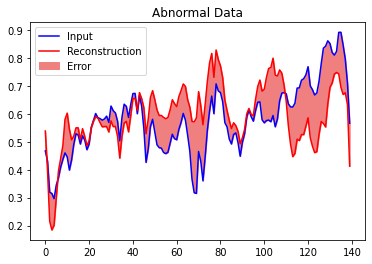

In [63]:
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('Abnormal Data')
plt.show()

In [56]:
test_data = pd.DataFrame(test_data)
test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139
0,0.616539,0.404827,0.200784,0.201516,0.226450,0.369520,0.497483,0.527075,0.613073,0.731662,0.772992,0.707652,0.657714,0.671205,0.695857,0.696280,0.643584,0.673263,0.687742,0.645127,0.643187,0.682212,0.690025,0.706225,0.698771,0.674161,0.656726,0.667765,0.651595,0.641850,0.648696,0.622445,0.621771,0.583861,0.523219,0.589628,0.620530,0.604255,0.575400,0.630846,...,0.741503,0.790774,0.861618,0.833388,0.840526,0.754172,0.718918,0.744637,0.684646,0.616662,0.526288,0.375696,0.289497,0.234725,0.267479,0.336678,0.319697,0.344632,0.361437,0.384807,0.429175,0.329801,0.296804,0.277712,0.283890,0.373633,0.433638,0.405771,0.386731,0.484786,0.588490,0.581377,0.632752,0.657796,0.612855,0.568779,0.541744,0.598968,0.653996,0.362585
1,0.467621,0.430766,0.319465,0.314874,0.296118,0.344687,0.370738,0.408974,0.436478,0.460203,0.446257,0.398630,0.434626,0.490835,0.528812,0.524703,0.492032,0.521091,0.506453,0.471728,0.491788,0.552214,0.577353,0.601456,0.586400,0.583343,0.577584,0.581938,0.592115,0.569477,0.628367,0.611677,0.603653,0.573786,0.503352,0.587203,0.634861,0.627014,0.587319,0.633065,...,0.568106,0.576151,0.578041,0.571973,0.594346,0.553939,0.581236,0.646721,0.674362,0.676741,0.672731,0.635787,0.625233,0.624763,0.638422,0.692607,0.693561,0.720899,0.726331,0.739943,0.769251,0.700510,0.687089,0.667825,0.675205,0.717072,0.779195,0.835668,0.842828,0.862103,0.852274,0.820373,0.810691,0.824090,0.892340,0.892701,0.847112,0.796291,0.709927,0.566666
2,0.580754,0.358502,0.133205,0.130140,0.176492,0.336520,0.436362,0.439005,0.516487,0.639720,0.611446,0.538632,0.514323,0.525601,0.545173,0.540104,0.506647,0.544271,0.523300,0.489032,0.504233,0.548612,0.565133,0.583894,0.587565,0.563070,0.533952,0.563935,0.554637,0.512585,0.559701,0.546326,0.521223,0.490044,0.412653,0.487979,0.538832,0.537720,0.491509,0.557237,...,0.676624,0.727539,0.749220,0.752520,0.823804,0.762461,0.762838,0.838683,0.820740,0.786455,0.727731,0.625401,0.550751,0.483176,0.474915,0.496255,0.510394,0.529450,0.534423,0.563860,0.591303,0.525501,0.476970,0.480020,0.480289,0.525163,0.572668,0.553761,0.549161,0.579461,0.651683,0.738759,0.791455,0.810723,0.820083,0.747479,0.682915,0.637415,0.659176,0.488215
3,0.578925,0.360070,0.073727,0.093420,0.303037,0.465542,0.466038,0.597072,0.672598,0.656884,0.596599,0.564195,0.550032,0.525605,0.540086,0.528135,0.493678,0.505897,0.519686,0.439135,0.486123,0.529196,0.542328,0.560338,0.519899,0.536834,0.512295,0.487875,0.476686,0.474169,0.476472,0.476681,0.463530,0.450707,0.367501,0.468958,0.502540,0.510863,0.468719,0.532988,...,0.534505,0.528107,0.527129,0.513348,0.577845,0.541389,0.629043,0.750984,0.771204,0.744790,0.693863,0.577902,0.577275,0.580833,0.566957,0.545238,0.531036,0.541403,0.527981,0.554460,0.608480,0.493546,0.494313,0.521562,0.475347,0.506084,0.592363,0.591157,0.562302,0.616313,0.672573,0.752805,0.842259,0.871318,0.898936,0.822637,0.748047,0.749513,0.736542,0.468094
4,0.587740,0.614884,0.629014,0.650866,0.595651,0.620210,0.532028,0.466503,0.415887,0.390317,0.363867,0.284418,0.288931,0.375054,0.481292,0.543417,0.512945,0.563334,0.581830,0.589929,0.627757,0.686552,0.719359,0.728960,0.727115,0.727017,0.723155,0.726413,0.741330,0.731129,0.759874,0.742314,0.747895,0.719893,0.687863,0.745717,0.773174,0.780209,0.760648,0.794801,...,0.597761,0.604382,0.601732,0.585144,0.596997,0.552502,0.579265,0.616457,0.634415,0.644862,0.633633,0.583572,0.565461,0.540201,0.555628,0.614695,0.616276,0.635872,0.624866,0.626530,0.644571,0.554624,0.482231,0.434379,0.430803,0.479423,0.504454,0.445889,0.357931,0.327482,0.256652,0.178917,0.114850,0.095291,0.086398,0.144142,0.206433,0.360059,0.385816,0.423418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [57]:
test_labels = test_labels.astype(int)
test_labels = pd.DataFrame(test_labels, columns=['label'])
test_labels

,label
0,1
1,0
2,1
3,1
4,0
...,...
995,0
996,1
997,1
998,1


In [58]:
test_Data = pd.concat([test_data, test_labels], axis=1)
test_Data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,label
0,0.616539,0.404827,0.200784,0.201516,0.226450,0.369520,0.497483,0.527075,0.613073,0.731662,0.772992,0.707652,0.657714,0.671205,0.695857,0.696280,0.643584,0.673263,0.687742,0.645127,0.643187,0.682212,0.690025,0.706225,0.698771,0.674161,0.656726,0.667765,0.651595,0.641850,0.648696,0.622445,0.621771,0.583861,0.523219,0.589628,0.620530,0.604255,0.575400,0.630846,...,0.790774,0.861618,0.833388,0.840526,0.754172,0.718918,0.744637,0.684646,0.616662,0.526288,0.375696,0.289497,0.234725,0.267479,0.336678,0.319697,0.344632,0.361437,0.384807,0.429175,0.329801,0.296804,0.277712,0.283890,0.373633,0.433638,0.405771,0.386731,0.484786,0.588490,0.581377,0.632752,0.657796,0.612855,0.568779,0.541744,0.598968,0.653996,0.362585,1
1,0.467621,0.430766,0.319465,0.314874,0.296118,0.344687,0.370738,0.408974,0.436478,0.460203,0.446257,0.398630,0.434626,0.490835,0.528812,0.524703,0.492032,0.521091,0.506453,0.471728,0.491788,0.552214,0.577353,0.601456,0.586400,0.583343,0.577584,0.581938,0.592115,0.569477,0.628367,0.611677,0.603653,0.573786,0.503352,0.587203,0.634861,0.627014,0.587319,0.633065,...,0.576151,0.578041,0.571973,0.594346,0.553939,0.581236,0.646721,0.674362,0.676741,0.672731,0.635787,0.625233,0.624763,0.638422,0.692607,0.693561,0.720899,0.726331,0.739943,0.769251,0.700510,0.687089,0.667825,0.675205,0.717072,0.779195,0.835668,0.842828,0.862103,0.852274,0.820373,0.810691,0.824090,0.892340,0.892701,0.847112,0.796291,0.709927,0.566666,0
2,0.580754,0.358502,0.133205,0.130140,0.176492,0.336520,0.436362,0.439005,0.516487,0.639720,0.611446,0.538632,0.514323,0.525601,0.545173,0.540104,0.506647,0.544271,0.523300,0.489032,0.504233,0.548612,0.565133,0.583894,0.587565,0.563070,0.533952,0.563935,0.554637,0.512585,0.559701,0.546326,0.521223,0.490044,0.412653,0.487979,0.538832,0.537720,0.491509,0.557237,...,0.727539,0.749220,0.752520,0.823804,0.762461,0.762838,0.838683,0.820740,0.786455,0.727731,0.625401,0.550751,0.483176,0.474915,0.496255,0.510394,0.529450,0.534423,0.563860,0.591303,0.525501,0.476970,0.480020,0.480289,0.525163,0.572668,0.553761,0.549161,0.579461,0.651683,0.738759,0.791455,0.810723,0.820083,0.747479,0.682915,0.637415,0.659176,0.488215,1
3,0.578925,0.360070,0.073727,0.093420,0.303037,0.465542,0.466038,0.597072,0.672598,0.656884,0.596599,0.564195,0.550032,0.525605,0.540086,0.528135,0.493678,0.505897,0.519686,0.439135,0.486123,0.529196,0.542328,0.560338,0.519899,0.536834,0.512295,0.487875,0.476686,0.474169,0.476472,0.476681,0.463530,0.450707,0.367501,0.468958,0.502540,0.510863,0.468719,0.532988,...,0.528107,0.527129,0.513348,0.577845,0.541389,0.629043,0.750984,0.771204,0.744790,0.693863,0.577902,0.577275,0.580833,0.566957,0.545238,0.531036,0.541403,0.527981,0.554460,0.608480,0.493546,0.494313,0.521562,0.475347,0.506084,0.592363,0.591157,0.562302,0.616313,0.672573,0.752805,0.842259,0.871318,0.898936,0.822637,0.748047,0.749513,0.736542,0.468094,1
4,0.587740,0.614884,0.629014,0.650866,0.595651,0.620210,0.532028,0.466503,0.415887,0.390317,0.363867,0.284418,0.288931,0.375054,0.481292,0.543417,0.512945,0.563334,0.581830,0.589929,0.627757,0.686552,0.719359,0.728960,0.727115,0.727017,0.723155,0.726413,0.741330,0.731129,0.759874,0.742314,0.747895,0.719893,0.687863,0.745717,0.773174,0.780209,0.760648,0.794801,...,0.604382,0.601732,0.585144,0.596997,0.552502,0.579265,0.616457,0.634415,0.644862,0.633633,0.583572,0.565461,0.540201,0.555628,0.614695,0.616276,0.635872,0.624866,0.626530,0.644571,0.554624,0.482231,0.434379,0.430803,0.479423,0.504454,0.445889,0.357931,0.327482,0.256652,0.178917,0.114850,0.095291,0.086398,0.144142,0.206433,0.360059,0.385816,0.423418,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [59]:
model.eval()
loss_dist = []
anom = test_Data
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i:i+1,:-1])).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

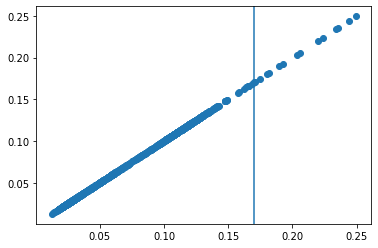

In [60]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.17, 0.0, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


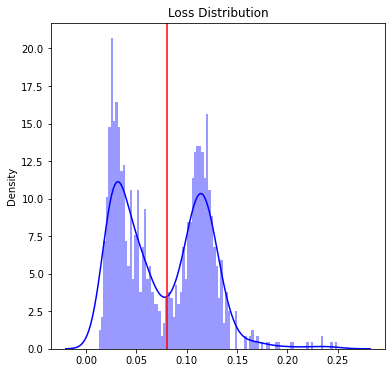

In [61]:
upper_threshold = 0.08
plt.figure(figsize=(6,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')

In [45]:
df = test_Data
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] <= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 514	[FP] 5	[MISSED] 46.0
[TN] 435	[FN] 46


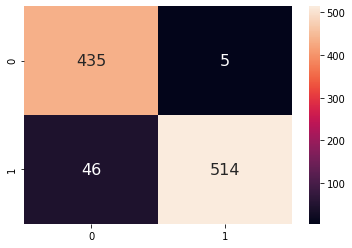

In [46]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

In [47]:
y_pred = loss_dist

th = upper_threshold
for i in range(len(y_pred)):
  if y_pred[i]>th:
    y_pred[i] = -1
  else:
    y_pred[i] = 1

label = anom['label']

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
gt_list = np.asarray(label)
fpr, tpr, _ = roc_curve(gt_list, loss_dist)
img_roc_auc = roc_auc_score(gt_list, loss_dist)

ROCAUC: 0.953


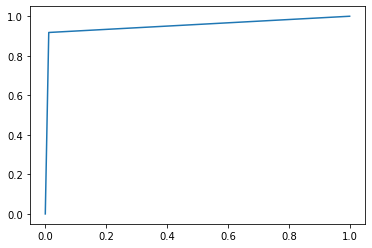

In [49]:
plt.plot(fpr, tpr, label='ROCAUC: %.3f' % (img_roc_auc))
print(f'ROCAUC: {img_roc_auc:.3f}')